In [1]:
from typing import Dict

import matplotlib.pyplot as plt
from torch import Tensor, arange, argwhere, atan2, cat, cos, diff
from torch import empty as empty_tensor
from torch import (
    float32,
    gradient,
    linspace,
    logical_and,
    meshgrid,
    norm,
    pi,
    sin,
    stack,
    tensor,
    where,
    zeros,
    zeros_like,
)
from torch.nn import functional as F

from beam_properties import (
    beams_boundaries_radians,
    get_beams_masks,
    get_beams_weighted_center,
    sample_ppdf_on_arc_2d_local,
)
from convex_hull_helper import convex_hull_2d, sort_points_for_hull_batch_2d
from geom_2d_plot import (
    plot_new_ppdf_mpl,
    plot_polygons_from_vertices_mpl,
    plot_scanner_from_vertices_2d_mpl,
)
from geometry_2d_io import load_scanner_layout_geometries, load_scanner_layouts
from geometry_2d_utils import (
    fov_tensor_dict,
    pixels_coordinates,
    pixels_to_detector_unit_rads,
)
from ppdf_io import load_ppdfs_data_from_hdf5

In [2]:
scanner_layouts_dir = "../../../pymatcal/scanner_layouts"
scanner_layouts_filename = "scanner_layouts_77faff53af5863ca146878c7c496c75e.tensor"

ppdfs_dataset_dir = (
    "../../../../data/scanner_layouts_77faff53af5863ca146878c7c496c75e"
)

# Load the scanner layouts
scanner_layouts_data, filename_unique_id = load_scanner_layouts(
    scanner_layouts_dir, scanner_layouts_filename
)

# Define the Field of View (FOV) tensor dictionary


fov_dict = fov_tensor_dict(
    n_pixels=(512, 512),
    mm_per_pixel=(0.25, 0.25),
    center_coordinates=(0.0, 0.0),
)
fov_points_2d = pixels_coordinates(fov_dict)

In [3]:
# Define the layout index to load
layout_idx = 0

# Load the scanner geometry
plates_vertices, detector_units_vertices = load_scanner_layout_geometries(
    layout_idx, scanner_layouts_data
)

# Set the PPDFs filename for a particular scanner position
ppdfs_hdf5_filename = f"position_{layout_idx:03d}_ppdfs.hdf5"

# Load the PPDFs data
ppdfs = load_ppdfs_data_from_hdf5(
    ppdfs_dataset_dir, ppdfs_hdf5_filename, fov_dict
)

# Print the shapes of the loaded data
print(
    f"Layout {layout_idx}:\n"
    + f"Metal plates shape  : {list(plates_vertices.shape)}\n"
    + f"Detector units shape: {list(detector_units_vertices.shape)}\n"
    + f"PPDFs data shape:     {list(ppdfs.shape)}"
)

detector_unit_centers = detector_units_vertices.mean(dim=1)
fov_corners = (
    tensor([[-1, -1], [1, -1], [1, 1], [-1, 1]]) * fov_dict["size in mm"] * 0.5
)

hull_points_batch = cat(
    (
        fov_corners.unsqueeze(0).expand(
            detector_units_vertices.shape[0], -1, -1
        ),
        detector_unit_centers.unsqueeze(1),
    ),
    dim=1,
)
hull_points_batch = sort_points_for_hull_batch_2d(hull_points_batch)


Layout 0:
Metal plates shape  : [88, 4, 2]
Detector units shape: [726, 4, 2]
PPDFs data shape:     [726, 262144]


N beams: 9


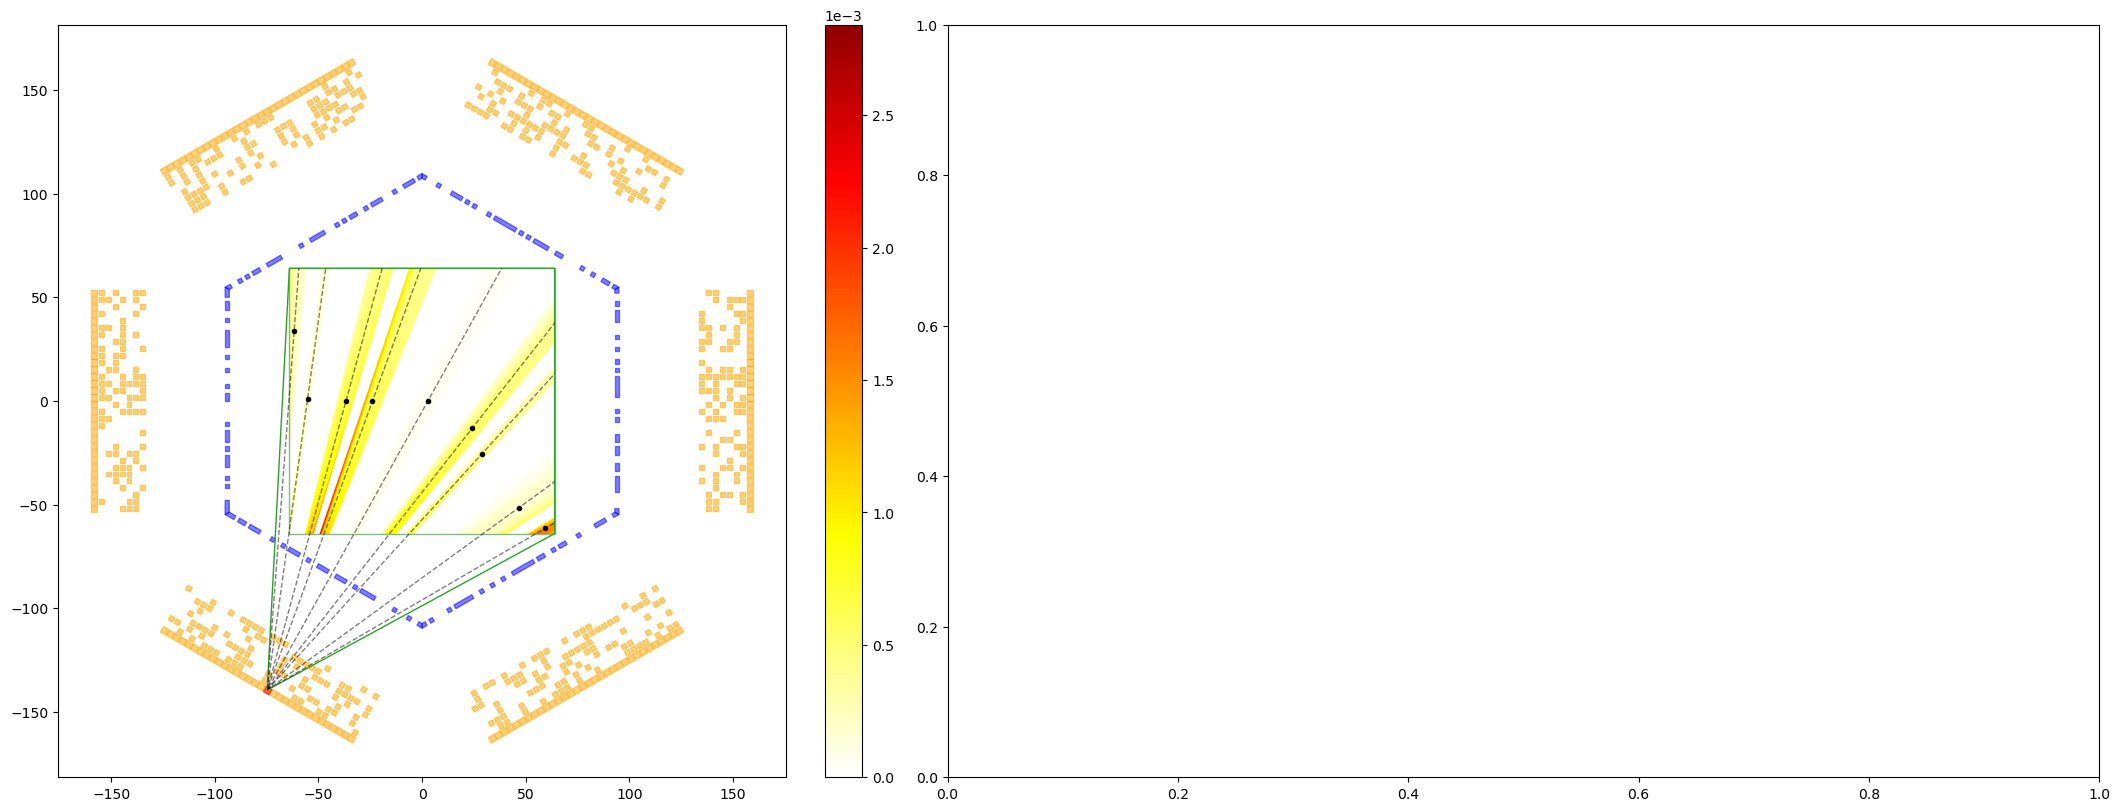

In [ ]:
detector_unit_idx = 590
ppdf_data_2d = ppdfs[detector_unit_idx].view(
    int(fov_dict["n pixels"][0]), int(fov_dict["n pixels"][1])
)
# Calculate the convex hull for the detector unit
hull_2d = convex_hull_2d(hull_points_batch[detector_unit_idx])

# Sample the PPDFs on the arc of the convex hull
(sampled_ppdf, sampling_rads, sampling_points) = sample_ppdf_on_arc_2d_local(
    ppdf_data_2d, detector_unit_centers[detector_unit_idx], hull_2d, fov_dict
)

relative_sampled_ppdf = sampled_ppdf / sampled_ppdf.max()
beams_boundaries = beams_boundaries_radians(sampled_ppdf, sampling_rads, threshold=0.01)

fov_points_xy = pixels_coordinates(fov_dict)
fov_points_rads = pixels_to_detector_unit_rads(
    fov_points_xy,
    detector_unit_centers[detector_unit_idx],
)
beams_masks = get_beams_masks(
    fov_points_rads,
    beams_boundaries,
)
beams_weighted_centers = get_beams_weighted_center(
    beams_masks,
    fov_points_xy,
    ppdf_data_2d,
)
beams_angles = get_beams_angle_radian(
    beams_weighted_centers,
    detector_unit_centers[detector_unit_idx],
)
print(f"N beams: {beams_boundaries.shape[0]}")
plt.close("all")
# Plot the PPDFs and the scanner layout
fig, axs = plt.subplots(
    1,
    2,
    figsize=(21, 8),
    layout="constrained",
    gridspec_kw={"width_ratios": (1, 1.5)},
)

scanner_polycoll = plot_scanner_from_vertices_2d_mpl(
    plates_vertices, detector_units_vertices, axs[0], fov_dict
)
selected_detector_unit_polycoll = plot_polygons_from_vertices_mpl(
    detector_units_vertices[detector_unit_idx].unsqueeze(0),
    axs[0],
    color="red",
    alpha=0.5,
)

hull_mpl_obj = plot_polygons_from_vertices_mpl(
    hull_2d.unsqueeze(0), axs[0], visible=True, fc="none", ec="C2"
)


ppdf_data_2d = ppdfs[detector_unit_idx].view(
    int(fov_dict["n pixels"][0]), int(fov_dict["n pixels"][1])
)
ppdf_im_obj = plot_new_ppdf_mpl(
    ppdf_data_2d,
    axs[0],
    fov_dict,
)
axs[0].autoscale()
axs[0].set_aspect("equal")


for center in beams_weighted_centers:
    axs[0].plot(
        center[0].item(),
        center[1].item(),
        "o",
        color="k",
        markersize=3,
        label="Beam center",
    )
    beam_axial_line = axs[0].axline(
        xy1=(center),
        xy2=(detector_unit_centers[detector_unit_idx]),
        color="k",
        linestyle="--",
        linewidth=1,
        alpha=0.5,
    )
    beam_axial_line.set_clip_path(hull_mpl_obj.get_paths()[0], transform=beam_axial_line.axes.transData)

In [17]:
print(
    f"Beam angles (deg): {beams_angles * 180 / pi}"
)

Beam angles (deg): tensor([210.1972, 215.9304, 227.7219, 231.9360, 240.9268, 249.9838, 254.7489,
        262.1025, 265.7057])
